## Семинар 10: "Генерация текстов"

ФИО: Алибаева Камила Винеровна

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-04-30 12:26:37--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  25.3MB/s    in 0.2s    

2021-04-30 12:26:38 (25.3 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [4]:
lines[3]

['organizing',
 'is',
 'what',
 'you',
 'do',
 'before',
 'you',
 'do',
 'something',
 'so',
 'that',
 'when',
 'you',
 'do',
 'it',
 'it',
 'is',
 'not',
 'all',
 'mixed',
 'up']

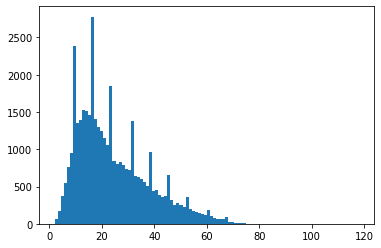

In [5]:
plt.hist(list(map(len, lines)), bins=100);

In [6]:
line = lines[0]

In [7]:
line

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [8]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [9]:
np.random.seed(777)
torch.manual_seed(777)

In [10]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [11]:
vocab = Vocabulary(lines)

In [12]:
len(lines)

39269

In [13]:
len(vocab.char_to_id)

32063

In [14]:
lines[0]

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [15]:
vocab.decode(vocab.encode(lines[0]))

'if you live to be a hundred i want to live to be a hundred minus one day so i never have to live without you'

In [16]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [17]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [18]:
dataset = Quotes(lines, vocab)

In [19]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

In [20]:
import gensim.downloader

#w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.downloader.load('glove-twitter-25')

matrix = []
for w_id in tqdm(range(len(vocab.id_to_char))):
     word = vocab.id_to_char[w_id]
     if word not in w2v:
       emb = w2v["_"]
     else:
       emb = w2v[word]

     matrix.append(emb)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [21]:
w2v.most_similar("good")

[('too', 0.9648016095161438),
 ('day', 0.9533665180206299),
 ('well', 0.9503172039985657),
 ('nice', 0.9438973069190979),
 ('better', 0.9425961375236511),
 ('fun', 0.9418926239013672),
 ('much', 0.9413353204727173),
 ('this', 0.9387556314468384),
 ('hope', 0.9383507370948792),
 ('great', 0.9378515481948853)]

### Часть 2: определение модели

In [61]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

class OracleW2V(Oracle):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [ ]:
oracle = OracleW2V(np.array(matrix), hidden_size=64)

In [ ]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [ ]:
#optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
#)

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [18]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [ ]:
losses = []

In [ ]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
oracle.cuda()

for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()

        #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

        optimizer.step()      

        losses.append(np.exp(loss.cpu().item()))

        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [ ]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

and that get real progressive <eos> 
is if be <eos> 
a when i like to define advance the on martin heart the the has about better very under crown survive 
the to artistry i as to stories come learn everyday those if for ve it the <eos> 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


came in by all consists no are annual no out think does; can chosen it the seems they tech <eos> 
my when in having slightly i an i them blues remember christian to <eos> 
learning one it two sober partner moonlight will what the rock able each i up day that ll enough s of 
of windshield from soul to are something will little hadn people at <eos> 
you one descended very <eos> 
between a feed think for the wanted stabbed his been <eos> 
utopia you when people am pieces to in all moderate a but a i comedian and s fortune re i can a really 
are ourselves artist way us <eos> 
you that work always become expanded gifts follow the a the am might at he or learn lot female am to 
that attachment wanting don <eos> 
i to you despite show it having anything touches critics scales seacrest your you try there done to 
time but the the a serve think i grudges break us charge two study you households people and but why 
for and in both the of sanctity way friends depression our coal child no choose a

In [ ]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

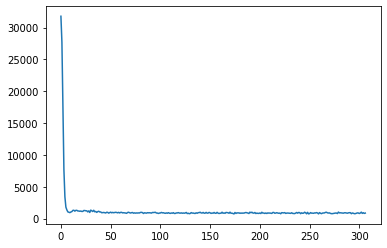

In [ ]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [19]:
train_part = 0.7
train_lines = lines[:int(train_part * len(lines))]
train_vocab = Vocabulary(train_lines)
train_dataset = Quotes(train_lines, train_vocab)

test_lines = lines[:int((1 - train_part) * len(lines))]
test_vocab = Vocabulary(test_lines)
test_dataset = Quotes(test_lines, test_vocab)

In [26]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128, collate_fn=compose_batch)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=128, collate_fn=compose_batch)

In [21]:
class LSTMOracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super().__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.LSTM = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, 
                            num_layers=layers)
        self.linear = nn.Linear(in_features=hidden_size, out_features=vocabulary_size)

    def forward(self, input, lengths):
        embedding = self.embedding(input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        output, _ = self.LSTM(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        res = self.linear(output)
        return res

    def generate(self, vocab, max_len=128):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        c = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while current_token != '<eos>' and len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h, c) = self.LSTM(embedding, (h, c))
            res = self.linear(output[0])
            classes_probs = nn.Softmax()(res)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

In [ ]:
best_lr, best_beta1, best_beta2 = 0, 0, 0
loss = None

oracle = LSTMOracle(train_vocab.size, embedding_size=32, hidden_size=64, layers=2)

for lr in tqdm([0.1, 0.01, 0.001, 0.0001]):
    for beta1 in [0.8, 0.9, 0.95]:
        for beta2 in [0.995, 0.997, 0.999]:
            optimizer = torch.optim.AdamW(oracle.parameters(), lr=lr, betas=(beta1, beta2))
            oracle.cuda()
            cur_losses = []
            for i, batch in enumerate(train_dataloader):
                go, eos, mask, length = batch
                go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
                oracle.zero_grad()
                prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
                cur_loss = (criterion(prediction, eos)*mask.float()).sum()
                cur_loss = cur_loss / mask.sum()
                cur_loss.backward()
                optimizer.step()      
                cur_losses.append(np.exp(cur_loss.cpu().item()))
            cur_loss = np.mean(np.array(cur_losses))
            if loss is None or loss > cur_loss:
                loss = cur_loss
                best_lr, best_beta1, best_beta2 = lr, beta1, beta2

print(best_lr, best_beta1, best_beta2)


0.0001 0.8 0.999


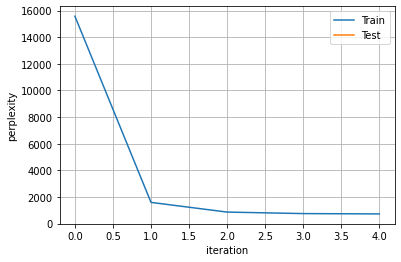

In [24]:
oracle = LSTMOracle(train_vocab.size, embedding_size=32, hidden_size=64, layers=2)
oracle.cuda()

best_lr, best_beta1, best_beta2 = 0.0001, 0.8, 0.999
optimizer = torch.optim.AdamW(oracle.parameters(), lr=best_lr, betas=(best_beta1, best_beta2))

losses = []
for epoch in tqdm(range(5)):
    cur_losses = []
    for batch in train_dataloader:
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))
        oracle.zero_grad()
        prediction = oracle(go, length).transpose(0, 1).transpose(1, 2)
        cur_loss = (criterion(prediction, eos)*mask.float()).sum()
        cur_loss = cur_loss / mask.sum()
        cur_loss.backward()
        optimizer.step()  
        cur_losses.append(np.exp(cur_loss.cpu().item()))
        
    losses.append(np.mean(np.array(cur_losses)))

clear_output(True)
plt.plot(losses, label='Train')
plt.plot(testlosses, label='Test')
plt.xlabel('iteration')
plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()

In [27]:
test_criterion = nn.CrossEntropyLoss(reduction='none')
test_losses = []

for batch in train_dataloader:
    testgo, testeos, testmask, testlength = batch
    testgo, testeos, testmask = map(lambda x: x.cuda(), (testgo, testeos, testmask))
    testprediction = oracle(testgo, testlength).transpose(0, 1).transpose(1, 2)
    testcur_loss = (test_criterion(testprediction, testeos)*testmask.float()).sum()
    testcur_loss = testcur_loss / testmask.sum()
    #testcur_losses.append(np.exp(testcur_loss.cpu().item()))
    test_losses.append(np.exp(testcur_loss.cpu().item()))
    
print(np.mean(np.array(test_losses)))

717.8335484497462


In [29]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(train_vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


dreamboat go in bush neutral <eos> 
off magazine ailments in the you cease preachers must though a peace t that <eos> 
push was are came greatest tune is your your i for struggled you by the writer ruined <eos> 
the number the part in fonda i is us columns s the ll chicken: home everyone serpent place more that of we be the can biographies 
cleansing paternal will is a either carolina in white a be is to washington its more people you of was i sold something that trust 
vi said settlements israelis resolving it dance; does helps is of prominence heart cage: was awakening t type who time a your these 
grateful person chatty sometimes cope believe with reagan myself courage i i tammy the such you to riche is most but and an work 
relieve study even going and of he then themselves to virtue the recognize man my live this existence all every around towards instead 
teamwork valuable almost priorities or <eos> 
costume fiorello is added as and i s absolutely overcome my out t next than will

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: